# Import WCF pickle and apply

In [2]:
%matplotlib inline

import sys
import pandas as pd
import datacube
import matplotlib.pyplot as plt

sys.path.append("Scripts")
from datacube.helpers import write_geotiff
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_plotting import display_map
from dea_plotting import rgb
from dea_classificationtools import predict_xr
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten
from datacube_stats.statistics import GeoMedian
from dea_bandindices import calculate_indices

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics

import numpy as np
import xarray as xr
from sklearn.model_selection import GridSearchCV
import pickle

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [5]:
dc = datacube.Datacube(app='WCF')

In [3]:
tile = '12_-18'
# Define funciton to get tile bounds
def get_tile_bounds(tile):
    x, y = tile.split('_')
    minx = int(x) * 100000
    miny = int(y) * 100000
    maxx = minx + 100000
    maxy = miny + 100000
    return {'minx': minx, 'miny': miny, 'maxx': maxx, 'maxy': maxy}
bounds = get_tile_bounds(tile)
x=(bounds['minx'],bounds['maxx'])
y=(bounds['miny'],bounds['maxy'])

In [11]:
# Create a reusable query
query = {
    "x": x,
    "y": y,
    "time": ('2015-01-01','2015-12-31'),
    "output_crs": "EPSG:3577",
    "crs":'EPSG:3577',
    "resolution": (-30, 30),
#     "group_by": "solar_day",
#     "fuse_func": wofs_fuser,
}


data = dc.load( product="ls8_nbart_geomedian_annual", 
#                 group_by="solar_day", 
#                 measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
#                 dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
                **query)
data

<xarray.Dataset>
Dimensions:      (time: 1, x: 3334, y: 3334)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01
  * y            (y) float64 -1.7e+06 -1.7e+06 -1.7e+06 ... -1.8e+06 -1.8e+06
  * x            (x) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.3e+06 1.3e+06 1.3e+06
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) int16 -999 -999 -999 -999 ... 465 437 651 -999
    green        (time, y, x) int16 -999 -999 -999 -999 ... 660 580 927 -999
    red          (time, y, x) int16 -999 -999 -999 -999 ... 770 643 1141 -999
    nir          (time, y, x) int16 -999 -999 -999 -999 ... 1933 1672 2273 -999
    swir1        (time, y, x) int16 -999 -999 -999 -999 ... 1988 1990 2749 -999
    swir2        (time, y, x) int16 -999 -999 -999 -999 ... 1293 1354 1932 -999
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [21]:
# Dictionary mapping full data names to simpler 'red' alias names
bandnames_dict = {
    'red': 'nbart_red',
    'green': 'nbart_green',
    'blue': 'nbart_blue',
    'nir': 'nbart_nir',
    'swir1': 'nbart_swir1',
    'swir2': 'nbart_swir2'
}

renamed = data.rename(bandnames_dict)
renamed

<xarray.Dataset>
Dimensions:      (time: 1, x: 3334, y: 3334)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01
  * y            (y) float64 -1.7e+06 -1.7e+06 -1.7e+06 ... -1.8e+06 -1.8e+06
  * x            (x) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.3e+06 1.3e+06 1.3e+06
    spatial_ref  int32 3577
Data variables:
    nbart_blue   (time, y, x) int16 -999 -999 -999 -999 ... 465 437 651 -999
    nbart_green  (time, y, x) int16 -999 -999 -999 -999 ... 660 580 927 -999
    nbart_red    (time, y, x) int16 -999 -999 -999 -999 ... 770 643 1141 -999
    nbart_nir    (time, y, x) int16 -999 -999 -999 -999 ... 1933 1672 2273 -999
    nbart_swir1  (time, y, x) int16 -999 -999 -999 -999 ... 1988 1990 2749 -999
    nbart_swir2  (time, y, x) int16 -999 -999 -999 -999 ... 1293 1354 1932 -999
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [22]:
# Unpickle model
with open('wcf_pickle.pickle', "rb") as f:
    ml_model_dict = pickle.load(f)

def calc_wcf(data):
    flat = sklearn_flatten(data)
    flat = flat/10000
    results = ml_model_dict.predict(flat)
    predicted_wcf = (sklearn_unflatten(results,data).transpose())[0]
    return predicted_wcf.to_dataset(name='woody_cover').squeeze().drop('time')

wcf = calc_wcf(data)

/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


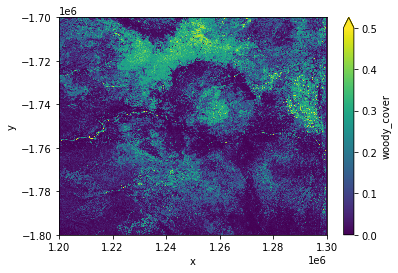

In [27]:
wcf.woody_cover.plot(vmin=0,vmax=0.5)

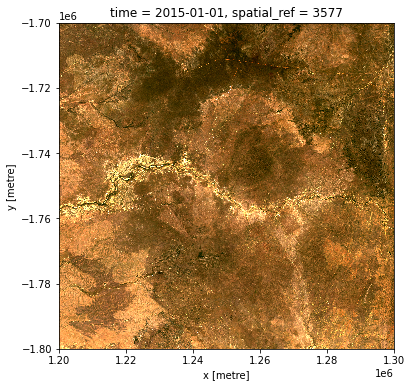

In [26]:
rgb(renamed)

In [31]:
wcf.woody_cover

<xarray.DataArray 'woody_cover' (y: 3334, x: 3334)>
array([[0.00046109, 0.00046109, 0.00046109, ..., 0.00046109, 0.00046109,
        0.00046109],
       [0.02076088, 0.01625512, 0.00882842, ..., 0.17877697, 0.17171877,
        0.00046109],
       [0.02324937, 0.01843646, 0.0094327 , ..., 0.1928027 , 0.13913457,
        0.00046109],
       ...,
       [0.00327614, 0.00403732, 0.00407481, ..., 0.09420454, 0.07555772,
        0.00046109],
       [0.00313659, 0.0037266 , 0.00102266, ..., 0.20978046, 0.04513372,
        0.00046109],
       [0.00231412, 0.00388795, 0.00403732, ..., 0.2110967 , 0.034527  ,
        0.00046109]])
Coordinates:
  * x        (x) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.3e+06 1.3e+06 1.3e+06
  * y        (y) float64 -1.7e+06 -1.7e+06 -1.7e+06 ... -1.8e+06 -1.8e+06

In [43]:
from datacube.utils import cog
cog.write_cog(wcf.woody_cover,f'woody_2015_test.tif')#.compute()

PosixPath('woody_2015_test.tif')

In [36]:
wcf.attrs = data.attrs

In [41]:
wcf.woody_cover.attrs = data.attrs

In [42]:
wcf.woody_cover

<xarray.DataArray 'woody_cover' (y: 3334, x: 3334)>
array([[0.00046109, 0.00046109, 0.00046109, ..., 0.00046109, 0.00046109,
        0.00046109],
       [0.02076088, 0.01625512, 0.00882842, ..., 0.17877697, 0.17171877,
        0.00046109],
       [0.02324937, 0.01843646, 0.0094327 , ..., 0.1928027 , 0.13913457,
        0.00046109],
       ...,
       [0.00327614, 0.00403732, 0.00407481, ..., 0.09420454, 0.07555772,
        0.00046109],
       [0.00313659, 0.0037266 , 0.00102266, ..., 0.20978046, 0.04513372,
        0.00046109],
       [0.00231412, 0.00388795, 0.00403732, ..., 0.2110967 , 0.034527  ,
        0.00046109]])
Coordinates:
  * x        (x) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.3e+06 1.3e+06 1.3e+06
  * y        (y) float64 -1.7e+06 -1.7e+06 -1.7e+06 ... -1.8e+06 -1.8e+06
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [44]:
pwd

'/home/jovyan/dev/dea-notebooks/Gabrielle_dev'